In [1]:
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [2]:
import lightning as L
import torch

In [3]:
from causalflows.scms import SCM, CausalEquations

In [4]:
from decaflow.utils.example_equations import SachsEquations, EmpiricalGaussianBase
from cdt.data import load_dataset
data_sachs, _ = load_dataset("sachs")
eq = SachsEquations(equations_type = 'additive')
graph = eq.graph
node_order = eq.node_order
base_dist = EmpiricalGaussianBase(graph, node_order, data_sachs)
u_samples = base_dist.sample((128,))
# scm =  SCM(equations=eq, base=base_dist)
scm = SCM(equations=eq, base='std-gaussian')

Detecting 1 CUDA device(s).


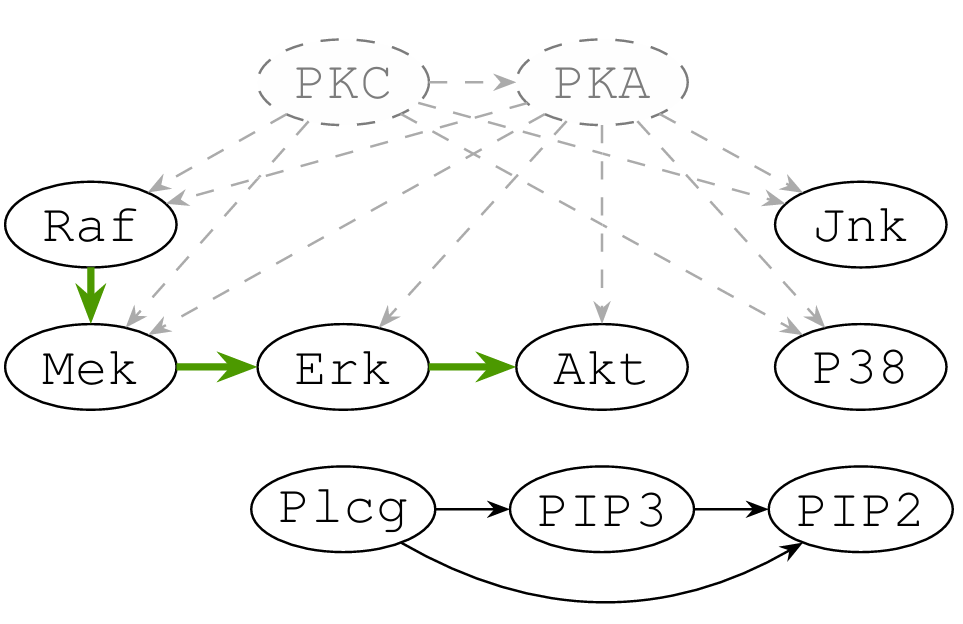

In [5]:
# insert ../assets/napkin_graph.png
from IPython.display import Image, display

display(Image(filename='../assets/sachs_graph.png'))

In [6]:
def generate_data(size: int):
    return scm.sample((size,))
def generate_int_data(size: int, index, value):
    return scm.sample_interventional(index, value, (size,))
columns = node_order

In [7]:
x = scm.sample((1,))

In [8]:
adjacency = scm.adjacency

In [9]:
from torch.utils.data import DataLoader, TensorDataset

In [10]:
num_hidden = 2
batch_size = 4096

train_size = 25000
train_data = generate_data(train_size)

test_size = int(train_size * 0.1)
test_data = generate_data(test_size)

# Standardize the data
mu, sigma = train_data.mean(dim=0), train_data.std(dim=0)
train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma

z_train, x_train = train_data[:, :num_hidden], train_data[:, num_hidden:]
z_test, x_test = test_data[:, :num_hidden], test_data[:, num_hidden:]

n_features = x_train.shape[1]

# Create the dataloaders
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True) #, num_workers=11)

test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=test_size)

In [11]:
from decaflow.models import Encoder, Decoder, DeCaFlow
from decaflow.utils.logger import MyLogger
encoder = Encoder(flow_type='nsf', num_hidden=num_hidden, adjacency=adjacency,
                  features=num_hidden, context=n_features, hidden_features=[64, 64],
                  activation=torch.nn.ReLU)
decoder = Decoder(flow_type='nsf', num_hidden=num_hidden, adjacency=adjacency,
                  features=n_features, context=num_hidden, hidden_features=[64, 64, 64],
                  activation=torch.nn.ReLU)
unaware_decoder = Decoder(flow_type='nsf', num_hidden=0, adjacency=adjacency[num_hidden:, num_hidden:],
                    features=n_features, context=0, hidden_features=[64, 64, 64],
                    activation=torch.nn.ReLU)
scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_config = {'mode': 'min', 'factor': 0.95, 'patience': 10, 'verbose': True, 'cooldown':0}

decaflow = DeCaFlow(encoder=encoder, flow=decoder,
                    regularize=True, warmup=100,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='train_loss')
unaware_flow = DeCaFlow(encoder=None, flow=unaware_decoder, regularize=False,
                    lr=1e-3, optimizer_cls=torch.optim.Adam,
                    scheduler_cls=scheduler_cls,
                    scheduler_kwargs=scheduler_config,
                    scheduler_monitor='train_loss')

In [12]:
logger = MyLogger()
trainer = L.Trainer(max_epochs=1000, logger=logger, enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer.fit(decaflow, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 7.9 K  | train
1 | flow    | Decoder | 22.5 K | train
--------------------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


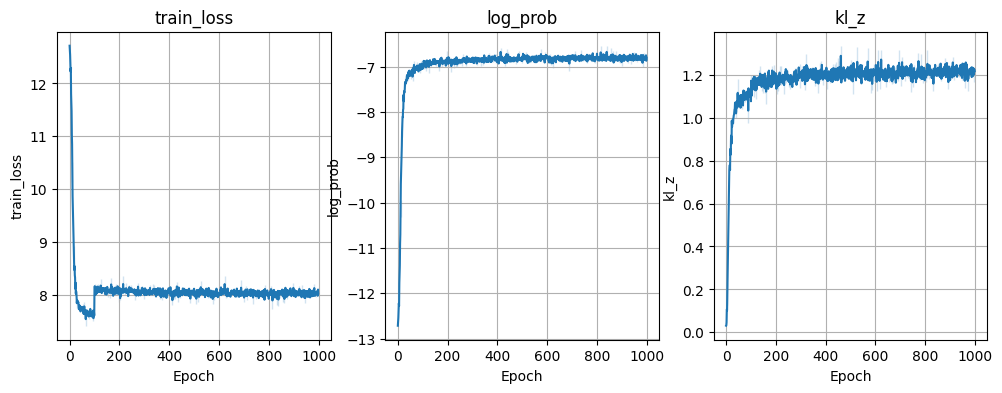

(8.01855182647705, -6.803020000457764, 1.2155314683914185)

In [13]:
from decaflow.utils.plot import plot_logs
plot_logs(logger, columns=['train_loss', 'log_prob', 'kl_z'])
logger.values['train_loss'][-1], logger.values['log_prob'][-1], logger.values['kl_z'][-1]

In [14]:
logger_unaware = MyLogger()
trainer_unaware  = L.Trainer(max_epochs=1000, logger=logger_unaware , enable_checkpointing=False, log_every_n_steps=len(train_loader)-1)
trainer_unaware.fit(unaware_flow, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | flow | Decoder | 22.4 K | train
-----------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Total params
0.090     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


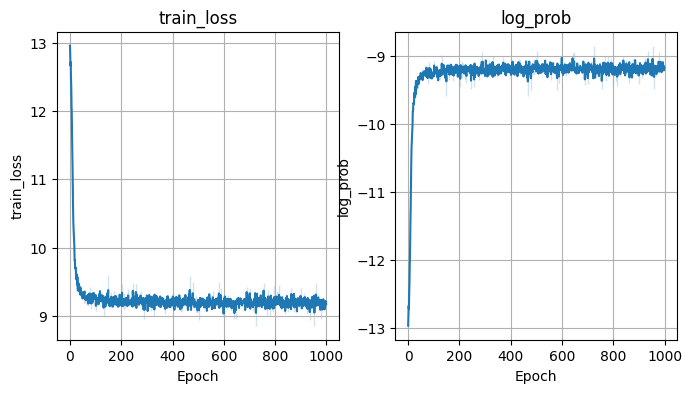

(9.171721458435059, -9.171721458435059)

In [15]:
plot_logs(logger_unaware, columns=['train_loss', 'log_prob'])
logger_unaware.values['train_loss'][-1], logger_unaware.values['log_prob'][-1]

In [16]:
x_gen, z_gen = decaflow.sample((test_size,))
gen_data = torch.cat((z_gen, x_gen), dim=1)
gen_data.shape

torch.Size([2500, 11])

In [17]:
x_gen_unaware, _ = unaware_flow.sample((test_size,))
gen_data_unaware = torch.cat((z_gen,x_gen_unaware), dim=1)

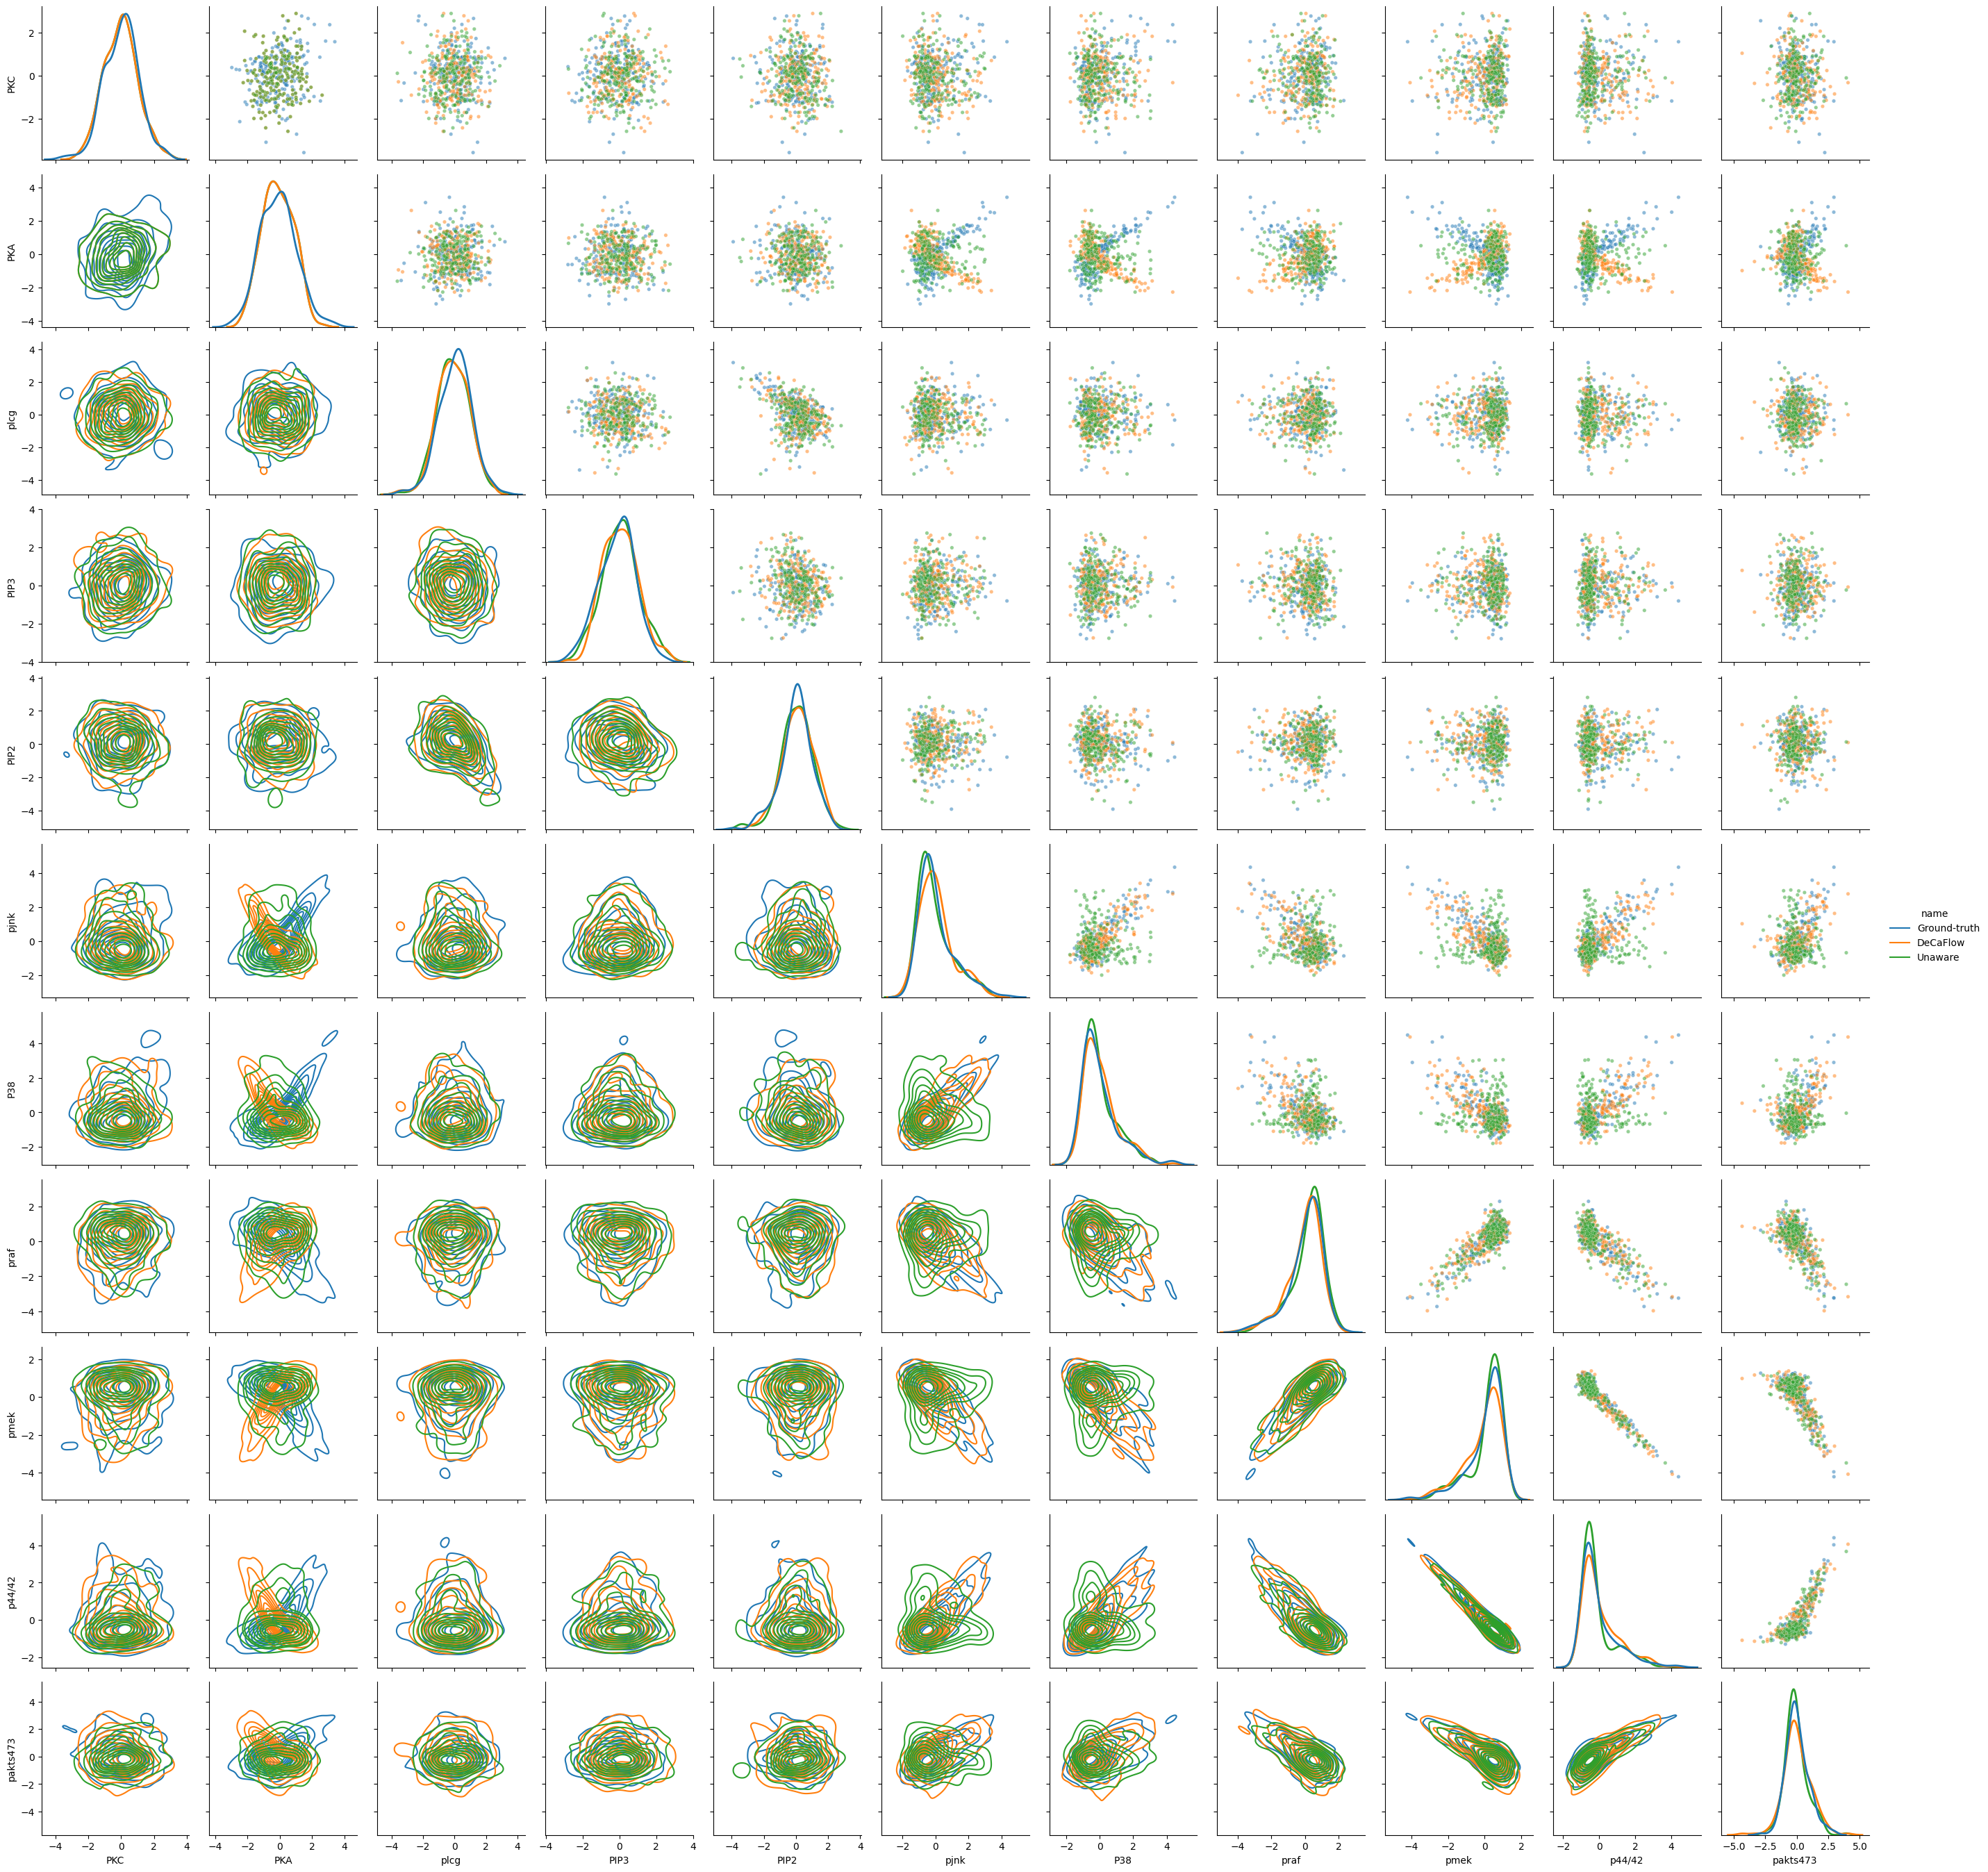

In [18]:
from decaflow.utils.plot import plot_data
num_samples = 200
g = plot_data({'Ground-truth': test_data[:num_samples], 'DeCaFlow': gen_data[:num_samples], 'Unaware':gen_data_unaware[:num_samples]}, columns=columns)

In [19]:
torch.quantile(train_data[:, -2], 0.99), torch.quantile(train_data[:, 4], 0.99)

(tensor(3.2485), tensor(2.0866))

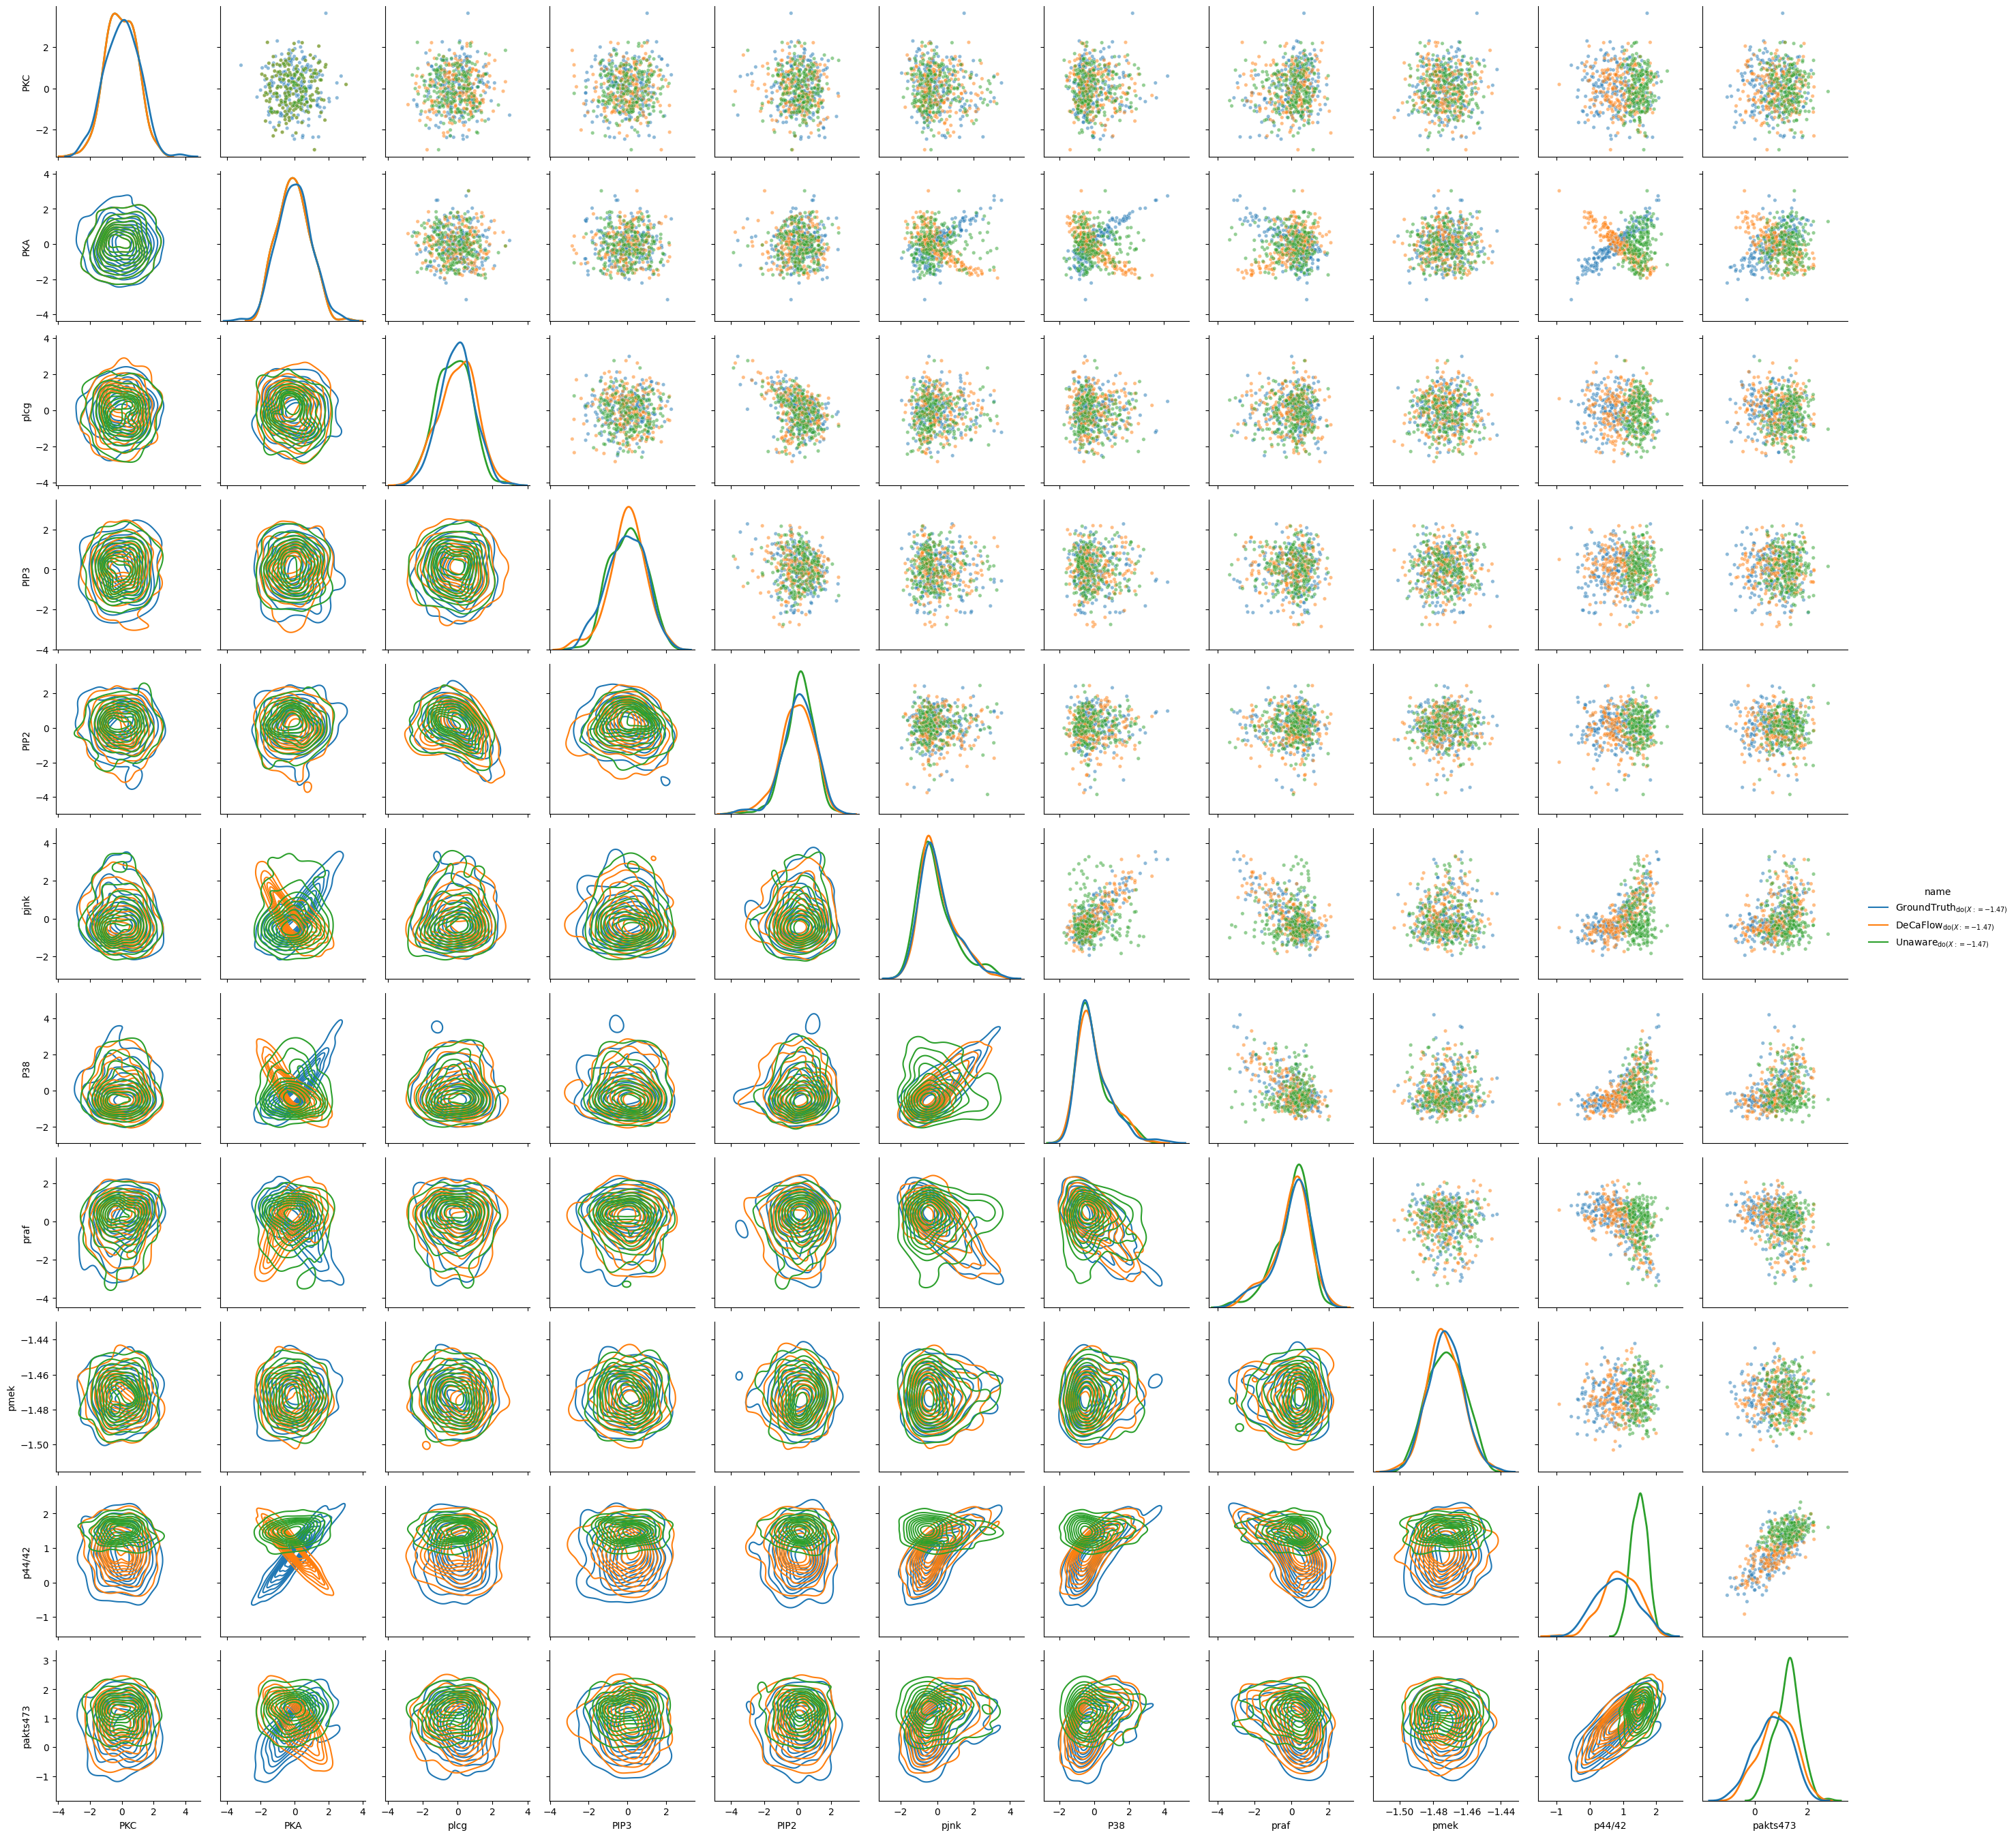

In [20]:
index_intervene = 8
value = torch.quantile(train_data[:, index_intervene], 0.1)

true_int_data = generate_int_data(test_size, index_intervene, value * sigma[index_intervene] + mu[index_intervene])
true_int_data = (true_int_data - mu) / sigma

#interventional data with decaflow
x_int, z_int = decaflow.sample_interventional(index_intervene-num_hidden, value, (test_size, ))
int_data = torch.cat((z_int, x_int), dim=1)

#interventional data with unaware flow
x_int_unaware, _ = unaware_flow.sample_interventional(index_intervene-num_hidden, value, (test_size, ))
int_data_unaware = torch.cat((z_int, x_int_unaware), dim=1)


int_data[:, index_intervene] += torch.randn((test_size,)) * 0.01
true_int_data[:,  index_intervene] += torch.randn((test_size,)) * 0.01
int_data_unaware[:, index_intervene] += torch.randn((test_size,)) * 0.01

g = plot_data({
    r'$\text{GroundTruth}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': true_int_data[:num_samples],
    r'$\text{DeCaFlow}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': int_data[:num_samples],
    r'$\text{Unaware}_{\mathrm{do}(X :=' + f'{float(value):.2f}' + r')}$': int_data_unaware[:num_samples],
}, columns=columns)



In [21]:
J = decaflow.compute_jacobian(x = x_test[:100])
display(J.mean(axis=0))

array([[ 0.98909193,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02027192,  0.9927069 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.0504509 ,  0.12745601,  1.2653255 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.1910179 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.4168928 ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.6152912 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.0663211 ,  2.9662194 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [22]:
J.mean(axis=0)

array([[ 0.98909193,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02027192,  0.9927069 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.0504509 ,  0.12745601,  1.2653255 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.1910179 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.4168928 ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.6152912 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.0663211 ,  2.9662194 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [23]:
p_u = torch.distributions.Normal(torch.zeros([100, n_features]), scale=1)
u = p_u.sample()
G = decaflow.compute_jacobian(u = u)
display(G.mean(axis=0))

array([[ 1.008629  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05445533,  1.0154653 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.24864136, -0.09933367,  0.78955835,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.4386493 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.4000119 ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.6966307 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.3009255 ,  0.33844835,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [24]:
G.mean(axis=0)

array([[ 1.008629  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05445533,  1.0154653 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.24864136, -0.09933367,  0.78955835,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.4386493 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.4000119 ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.6966307 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.3009255 ,  0.33844835,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [48]:
from decaflow.utils.metrics import get_ate_error, get_counterfactual_error
value_a = torch.quantile(train_data[:, index_intervene], 0.1)
value_b = torch.quantile(train_data[:, index_intervene], 0.9)
index_eval = [9, 10]
ate_error = get_ate_error(flow=decaflow, scm=scm, num_hidden=num_hidden,
                      index_intervene=index_intervene,
                      value_intervene_a=value_a, value_intervene_b=value_b,
                      index_eval=index_eval,
                      scm_scale=sigma, scm_loc=mu)
cf_error = get_counterfactual_error(flow=decaflow, scm=scm, num_hidden=num_hidden,
                                factual = test_data, # z and x
                                index_intervene=index_intervene,
                                value_intervene=value_a,
                                index_eval=index_eval,
                                scm_scale = sigma, scm_loc = mu)
print(f'ATE error: {ate_error:.4f}')
print(f'Counterfactual error: {cf_error:.4f}')

ATE error: 0.0820
Counterfactual error: 0.2739


In [49]:
# Unaware flow metrics
ate_error_unaware = get_ate_error(flow=unaware_flow, scm=scm, num_hidden=num_hidden,
                      index_intervene=index_intervene,
                      value_intervene_a=value_a, value_intervene_b=value_b,
                      index_eval=index_eval,
                      scm_scale = sigma, scm_loc = mu)
cf_error_unaware = get_counterfactual_error(flow=unaware_flow, scm=scm, num_hidden=num_hidden,
                                factual = test_data,  # z and x
                                index_intervene=index_intervene,
                                value_intervene=value_a,
                                index_eval=index_eval,
                                scm_scale = sigma, scm_loc= mu)
print(f'ATE error: {ate_error_unaware:.4f}')
print(f'Counterfactual error: {cf_error_unaware:.4f}')

ATE error: 0.5546
Counterfactual error: 0.5454


TADA! ATE and Counterfactual Error achieved by DeCaFlow are much lower than errors commited by an unaware flow!! :)